In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210102092406-0001
KERNEL_ID = 352cc86e-26ce-4b84-baf1-cdad2e7c4ccc


In [2]:

df = spark.read.json(cos.url('data_asset/medium_sparkify_event_data_json_7fp5iobkbj5gn8y8079sqjm2.json', 'capstone-donotdelete-pr-ts1gj8hvsnmbw4'))


In [3]:
# from pyspark.sql.types import IntegerType
import os
import sys
import requests
requests.packages.urllib3.disable_warnings()
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as mpl
mpl.rcParams['agg.path.chunksize'] = 100000
from matplotlib.gridspec import GridSpec

from pyspark import SQLContext
from pyspark.sql.functions import min, max, col, count, array
from pyspark.sql import SparkSession, functions as F
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, VectorSizeHint, StringIndexer, StandardScaler, ChiSqSelector
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.stat import Correlation
# from pyspark.ml.feature import VectorSizeHint
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
# Here we read in our intial data set and change some data types to numerical types.
df = df.withColumn('sessionId', col('sessionId').cast('int')) \
    .withColumn('ts', col('ts').cast('int')).dropDuplicates()
df = df.filter(df.userId != "").persist()
ac = df.columns


In [5]:
# Our initial exploratory analysis detailed there might be a difference between the paid and free users, so we run a separate pipeline to explore this concept.

paid = df.filter(df.level == 'paid').cache()
free = df.filter(df.level == 'free').cache()

oc = ['artistIndex', 'authIndex', 'genderIndex', 'levelIndex', 'locationIndex', 'methodIndex', 'pageIndex', 'songIndex', 'userAgentIndex', 'userIdIndex']
ic = ['artist', 'auth', 'gender', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

indexer = StringIndexer(inputCols = ic, outputCols = oc, handleInvalid = 'skip')
vecAssembler = VectorAssembler(inputCols=oc, outputCol = 'features')
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
css = ChiSqSelector(featuresCol = 'Scaled_features', outputCol = 'Aspect', labelCol = 'levelIndex', fpr = .05)
kMeans = KMeans(featuresCol = 'Aspect', predictionCol = 'prediction', k = 3, seed = 1)
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'Aspect')

pipeline = Pipeline(stages = [indexer, vecAssembler, standardscaler, css, kMeans])


In [11]:
# Calculating the pipeline for the paid users.
pipelineModel_paid = pipeline.fit(paid)
pred_pipelineModel_paid = pipelineModel_paid.transform(paid).cache()
evaluator.evaluate(pred_pipelineModel_paid)

0.3461477921378561

In [12]:
# Calculating the pipeline for the free users.
pipelineModel_free = pipeline.fit(free)
pred_pipelineModel_free = pipelineModel_free.transform(free).cache()
evaluator.evaluate(pred_pipelineModel_free)

0.388001570985771

In [13]:
# Rejoining the data to determine data fields from vectorized data.
predicted_df_free = pred_pipelineModel_free.join(free, on = free.columns)
predicted_df_paid = pred_pipelineModel_paid.join(paid, on = paid.columns)

In [15]:
# For an explorartory visual analysis of the paid data set
delta1 = predicted_df_free.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_free['prediction'] == 0)).toPandas()
delta2 = predicted_df_free.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_free['prediction'] == 1)).toPandas()
delta3 = predicted_df_free.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_free['prediction'] == 2)).toPandas()

In [16]:
# For an explorartory visual analysis of the free data set
gamma1 = predicted_df_paid.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_paid['prediction'] == 0)).toPandas()
gamma2 = predicted_df_paid.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_paid['prediction'] == 1)).toPandas()
gamma3 = predicted_df_paid.select('ts', 'levelIndex', 'length', 'prediction').filter((predicted_df_paid['prediction'] == 2)).toPandas()

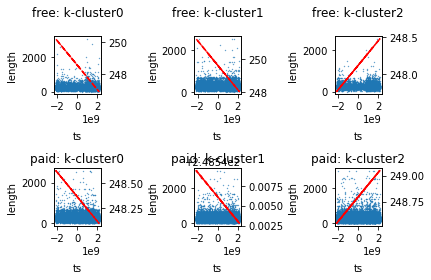

In [17]:
# Plotting the length of user usage between the paid, and free users over time.
z1 = np.polyfit(delta1.ts, delta1.length, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(delta2.ts, delta2.length, 1)
p2 = np.poly1d(z2)
z3 = np.polyfit(delta3.ts, delta3.length, 1)
p3 = np.poly1d(z3)

free_slope = [p1, p2, p3]

fig, axs = mpl.subplots(2, 3)
axs1 = axs[0, 0].twinx()
axs2 = axs[0, 1].twinx()
axs3 = axs[0, 2].twinx()

axs4 = axs[1, 0].twinx()
axs5 = axs[1, 1].twinx()
axs6 = axs[1, 2].twinx()

r = 0
while r < 2:
    cm = 0
    while cm < 3:
        if r == 0:
            axs[r, cm].set_title('free: k-cluster' + str(cm), pad =20)
            axs[r, cm].set_xlabel('ts', labelpad = 20)
            axs[r, cm].set_ylabel('length')
        else:
            axs[r, cm].set_title('paid: k-cluster' + str(cm))
            axs[r, cm].set_xlabel('ts', labelpad = 20)
            axs[r, cm].set_ylabel('length')
        cm += 1
    r += 1

axs[0, 0].scatter(delta1.ts, delta1.length, s = .1)
axs1.plot(delta1.ts, p1(delta1.ts), "r--")

axs[0, 1].scatter(delta2.ts, delta2.length, s = .1)
axs2.plot(delta2.ts, p2(delta2.ts), "r--")
axs[0, 2].scatter(delta3.ts, delta3.length, s = .1)
axs3.plot(delta3.ts, p3(delta3.ts), "r--")



z1 = np.polyfit(gamma1.ts, gamma1.length, 1)
p1 = np.poly1d(z1)
z2 = np.polyfit(gamma2.ts, gamma2.length, 1)
p2 = np.poly1d(z2)
z3 = np.polyfit(gamma3.ts, gamma3.length, 1)
p3 = np.poly1d(z3)

paid_slope = [p1, p2, p3]
    

axs[1, 0].scatter(gamma1.ts, gamma1.length, s = .1)
axs4.plot(gamma1.ts, p1(gamma1.ts), "r--")

axs[1, 1].scatter(gamma2.ts, gamma2.length, s = .1)
axs5.plot(gamma2.ts, p2(gamma2.ts), "r--")

axs[1, 2].scatter(gamma3.ts, gamma3.length, s = .1)
axs6.plot(gamma3.ts, p3(gamma3.ts), "r--")

fig.tight_layout()
mpl.show()

In [18]:
# The above plot would yields our data for further analysis. Three clusters within the free dataset users, has cluster 0 \
# with a positive trend line, and clusters 1, and 2 with negative length of usage.  We compare the slopes for a full analysis.
count = 0
analysis = ['these users probably leave the service altogether', 'these will continue free service', 'these users might upgrade']
print("Paid Users:")
print("-----------")
for each in paid_slope:
    print("Cluster", count, "has a slope of", each[1], 'indicating: ')
    print("    ", analysis[count])
    count += 1

Paid Users:
-----------
Cluster 0 has a slope of -1.216892248957201e-10 indicating: 
     these users probably leave the service altogether
Cluster 1 has a slope of -1.540164399800461e-12 indicating: 
     these will continue free service
Cluster 2 has a slope of 1.1757006641838125e-10 indicating: 
     these users might upgrade


In [19]:
count = 0
analysis = ['These users will stay', 'these might leave altogether', 'these users might downgrade']
print("Free Users:")
print("-----------")
for each in free_slope:
    print("Cluster", count, "has a slope of", each[1], 'indicating: ')
    print("    ", analysis[count])
    count += 1

Free Users:
-----------
Cluster 0 has a slope of -7.753512596943267e-10 indicating: 
     These users will stay
Cluster 1 has a slope of -7.356106554410936e-10 indicating: 
     these might leave altogether
Cluster 2 has a slope of 1.6717832063707339e-10 indicating: 
     these users might downgrade


In [42]:
indexer = StringIndexer(inputCols = ic, outputCols = oc, handleInvalid = 'skip')
vecAssembler = VectorAssembler(inputCols=oc, outputCol = 'features')
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
css = ChiSqSelector(featuresCol = 'Scaled_features', outputCol = 'Aspect', labelCol = 'levelIndex', fpr = .05)
kMeans = KMeans(featuresCol = 'Aspect', predictionCol = 'prediction', k = 3, seed = 1)
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'Aspect')


pipeline2 = Pipeline(stages = [indexer, vecAssembler, standardscaler, css, kMeans])


vals1 = []
vals2 = []



In [ ]:
pipelineModel_paid2 = pipeline2.fit(paid)
pred_pipelineModel_paid2 = pipelineModel_paid2.transform(paid).cache()

In [48]:
# Calculating the pipeline for the paid users.

hyper_parameters = ['numTopFeatures', 'percentile', 'fpr', 'fdr', 'fwe']

for each in hyper_parameters:
    css = ChiSqSelector(selectorType = 'fwe', featuresCol = 'Scaled_features', outputCol = 'Aspect', labelCol = 'levelIndex', fpr = .05)
    kMeans = KMeans(featuresCol = 'Aspect', predictionCol = 'prediction', k = 3, seed = 1, initMode = 'random', maxIter = 20)
    pipeline2 = Pipeline(stages = [indexer, vecAssembler, standardscaler, css, kMeans])
    vals1.append(str(each) + " " + str(evaluator.evaluate(pred_pipelineModel_paid2)))

In [49]:
vals1

['k-means|| 0.4462053949059093',
 'random 0.44620539490590944',
 '5 0.3622452590311906',
 '20 0.36224525903119065',
 '30 0.3622452590311904',
 'numTopFeatures 0.36224525903119076',
 'percentile 0.36224525903119076',
 'fpr 0.36224525903119054',
 'fdr 0.36224525903119054',
 'fwe 0.3622452590311908']

In [51]:
indexer = StringIndexer(inputCols = ic, outputCols = oc, handleInvalid = 'skip')
vecAssembler = VectorAssembler(inputCols=oc, outputCol = 'features')
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
css = ChiSqSelector(featuresCol = 'Scaled_features', outputCol = 'Aspect', labelCol = 'levelIndex', fpr = .05)
kMeans = KMeans(featuresCol = 'Aspect', predictionCol = 'prediction', k = 3, seed = 1)
evaluator = ClusteringEvaluator(predictionCol = 'prediction', featuresCol = 'Aspect')


pipeline2 = Pipeline(stages = [indexer, vecAssembler, standardscaler, css, kMeans])
# Calculating the pipeline for the free users.
pipelineModel_free2 = pipeline2.fit(free)
pred_pipelineModel_free2 = pipelineModel_free2.transform(free).cache()
evaluator.evaluate(pred_pipelineModel_free2)

# for each in hyper_parameters:
#     css = ChiSqSelector(selectorType = 'fwe', featuresCol = 'Scaled_features', outputCol = 'Aspect', labelCol = 'levelIndex', fpr = .05)
#     kMeans = KMeans(featuresCol = 'Aspect', predictionCol = 'prediction', k = 3, seed = 1, initMode = 'random', maxIter = 20)
#     pipeline2 = Pipeline(stages = [indexer, vecAssembler, standardscaler, css, kMeans])
#     vals2.append(str(each) + " " + str(evaluator.evaluate(pred_pipelineModel_paid2)))

0.33218322090036284